In [130]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#from ant_colony import AntColony

/kaggle/input/ant-colony-module/ant_colony.py
/kaggle/input/my-dataset/my_data.csv


Read Cleandiness data
Data was filtered.

In [131]:
import shutil
src='/kaggle/input/my-dataset/my_data.csv'
dest='/kaggle/working/my_data.csv'
shutil.copyfile(src, dest)

df = pd.read_csv(dest)

df.head()

,ID,Delivery_person_ID,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_taken(min),distance
0,2784,PUNERES13DEL03,18.562450,73.916619,18.652450,74.006619,21,13.787860
1,689B,PUNERES20DEL01,18.592718,73.773572,18.702718,73.883572,40,16.849940
2,36B8,PUNERES19DEL02,18.563934,73.915367,18.643935,73.995367,36,12.256076
3,3C5E,PUNERES04DEL01,18.514210,73.838429,18.624210,73.948429,12,16.853619
4,30C8,PUNERES19DEL02,18.563934,73.915367,18.693935,74.045367,30,19.914687


In [132]:
import math
def dt(start_latitude, start_longitude, end_latitude, end_longitude):
    # Convert latitude and longitude from degrees to radians
    start_latitude = math.radians(start_latitude)
    start_longitude = math.radians(start_longitude)
    end_latitude = math.radians(end_latitude)
    end_longitude = math.radians(end_longitude)

    # Radius of the Earth in kilometers
    R = 6371.0

    # Differences in coordinates
    delta_longitude = end_longitude - start_longitude
    delta_latitude = end_latitude - start_latitude

    # Haversine formula
    a = math.sin(delta_latitude / 2)**2 + math.cos(start_latitude) * math.cos(end_latitude) * math.sin(delta_longitude / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Calculate distance
    distance = R * c
    return distance

In [133]:
import networkx as nx
from itertools import combinations

G = nx.Graph()
total_delivery_distance=df['distance'].sum()
print(total_delivery_distance)
# Add edges to the graph
for _, row in df.iterrows():
    start = (row["Restaurant_latitude"], row["Restaurant_longitude"])
    end = (row["Delivery_location_latitude"], row["Delivery_location_longitude"])
    distance = row["distance"]
    #time=row['Time_taken(min)']
    G.add_node(start, type='restaurant')
    G.add_node(end, type='destination')
    G.add_edge(start, end, distance=distance,tao=0)


# Iterate through nodes with type='restaurant'
for node in G.nodes():
    if G.nodes[node].get('type') == 'restaurant':
        adjacent_nodes = G.neighbors(node)
        for adj_node in adjacent_nodes:
            total=0
            if G.nodes[adj_node].get('type') == 'destination':
                edge_weight = G.edges[node, adj_node]['distance']
                total+=1/edge_weight
                #print(f"Weight between {node} and {adj_node}: {edge_weight}")
            G.nodes[node]['weight'] = total/total_delivery_distance
            #G.add_node(node, attribute='value')
    

# Get the number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

# Print all edges with their attributes
print("\nEdges:")
for u, v, edge_attrs in G.edges(data=True):
    print(f"Edge: {u} <-> {v}")
    print("Attributes:", edge_attrs)
    print("------")


29902.485093221727
Number of nodes: 240
Number of edges: 220

Edges:
Edge: (18.56245, 73.916619) <-> (18.65245, 74.006619)
Attributes: {'distance': 13.787860239172549, 'tao': 0}
------
Edge: (18.56245, 73.916619) <-> (18.61245, 73.966619)
Attributes: {'distance': 7.660348489150972, 'tao': 0}
------
Edge: (18.56245, 73.916619) <-> (18.67245, 74.026619)
Attributes: {'distance': 16.851359915661256, 'tao': 0}
------
Edge: (18.56245, 73.916619) <-> (18.59245, 73.946619)
Attributes: {'distance': 4.596336792438924, 'tao': 0}
------
Edge: (18.56245, 73.916619) <-> (18.57245, 73.926619)
Attributes: {'distance': 1.5321547990764783, 'tao': 0}
------
Edge: (18.56245, 73.916619) <-> (18.64245, 73.996619)
Attributes: {'distance': 12.256046315965444, 'tao': 0}
------
Edge: (18.56245, 73.916619) <-> (18.62245, 73.976619)
Attributes: {'distance': 9.192290417405088, 'tao': 0}
------
Edge: (18.56245, 73.916619) <-> (18.60245, 73.956619)
Attributes: {'distance': 6.128363939648455, 'tao': 0}
------
Edge: (

In [134]:
# Find all nodes of type 'restaurant'
restaurant_nodes = [node for node in G.nodes() if G.nodes[node]['type'] == 'restaurant']

# Create edges between all pairs of 'restaurant' nodes
for i in range(len(restaurant_nodes)):
    for j in range(i + 1, len(restaurant_nodes)):
        node_i = restaurant_nodes[i]
        node_j = restaurant_nodes[j]
        #print(node_i,node_j)
        weight_i = G.nodes[node_i]['weight']
        weight_j = G.nodes[node_j]['weight']
        #G[node_i][node_j]['tao']=(weight_i+weight_j)/2
        G.add_edge(node_i,node_j,tao=(weight_i+weight_j)/2)

# Get the number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print("2Number of nodes:", num_nodes)
print("2Number of edges:", num_edges)

2Number of nodes: 240
2Number of edges: 410


In [135]:
# Creating a new subgraph containing only nodes where type='restaurant'
restaurant_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'restaurant']
G_restaurant = G.subgraph(restaurant_nodes)
# Print all edges with their attributes
print("\nEdges:")
for u, v, edge_attrs in G_restaurant.edges(data=True):
    print(f"Edge: {u} <-> {v}")
    print("Attributes:", edge_attrs)
    print("------")


Edges:
Edge: (18.520016, 73.830547) <-> (18.56245, 73.916619)
Attributes: {'tao': 5.196660048176054e-06}
------
Edge: (18.520016, 73.830547) <-> (18.592718, 73.773572)
Attributes: {'tao': 4.850309918094649e-06}
------
Edge: (18.520016, 73.830547) <-> (18.563934, 73.915367)
Attributes: {'tao': 1.455034316441367e-05}
------
Edge: (18.520016, 73.830547) <-> (18.51421, 73.838429)
Attributes: {'tao': 5.819982099386494e-06}
------
Edge: (18.520016, 73.830547) <-> (18.55144, 73.804855)
Attributes: {'tao': 4.629707776600885e-06}
------
Edge: (18.520016, 73.830547) <-> (18.593481, 73.785901)
Attributes: {'tao': 9.094719076422362e-06}
------
Edge: (18.520016, 73.830547) <-> (18.516216, 73.842527)
Attributes: {'tao': 4.62961069426571e-06}
------
Edge: (18.520016, 73.830547) <-> (18.530963, 73.828972)
Attributes: {'tao': 5.196523728352876e-06}
------
Edge: (18.520016, 73.830547) <-> (18.536562, 73.896485)
Attributes: {'tao': 5.0016825266049054e-06}
------
Edge: (18.520016, 73.830547) <-> (18.5436

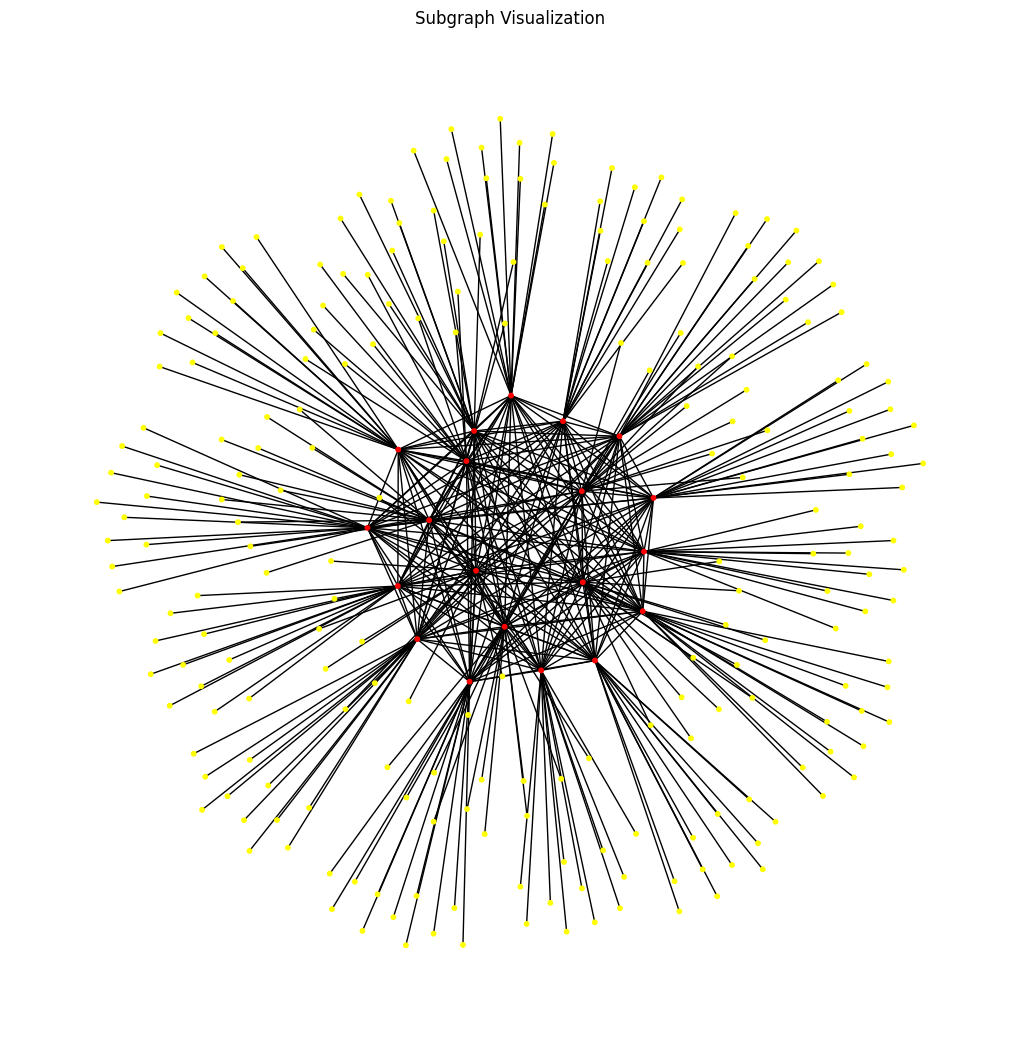

In [136]:
import matplotlib.pyplot as plt
# Extracting a subgraph with the first 100 nodes for visualization
subgraph_nodes = list(G.nodes())
subgraph = G.subgraph(subgraph_nodes)

color_map = {
    'restaurant': 'red',
    'destination': 'yellow'
}

# Extracting node colors based on their 'type' attribute
node_colors = [color_map[G.nodes[node]['type']] if 'type' in G.nodes[node] else 'blue' for node in G.nodes()]

# Plotting the subgraph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(subgraph)  # Layout algorithm
nx.draw(subgraph, pos, with_labels=False, node_size=10,node_color=node_colors)
plt.title("Subgraph Visualization")
plt.show()

In [145]:
import numpy as np
import math


# Compute the adjacency matrix with edge lengths
num_nodes = len(G_restaurant.nodes)
d_matrix = np.zeros((num_nodes, num_nodes))
tao_matrix = np.zeros((num_nodes, num_nodes))

#G_restaurant
for i, node1 in enumerate(G_restaurant.nodes):
    for j, node2 in enumerate(G_restaurant.nodes):
        if G_restaurant.has_edge(node1, node2):
            u1,u2=node1
            v1,v2=node2
            dis=dt(u1,u2,v1,v2)
            d_matrix[i, j] = dis
            tao_matrix[i, j] =G_restaurant[node1][node2]["tao"]
        

is_connected = nx.is_connected(G_restaurant)
print(is_connected)
d_matrix=np.array(d_matrix)
np.fill_diagonal(d_matrix, math.inf)
tao_matrix=np.array(tao_matrix)
print("d:")
print(d_matrix)
print("tao:")
print(tao_matrix)

True
d:
[[        inf  1.22852538 10.18857211  1.33194221  7.41084943  5.12130269
   9.42766112  7.33517981  8.03058306  8.28700636  4.42108635  8.30879761
   7.41791937  7.19126818 15.39801496  7.97210955 10.07095632  1.05236121
  10.22747225  1.8573225 ]
 [ 1.22852538         inf  9.81792422  2.17518231  7.4229377   4.15945007
   8.3029336   7.34054471  7.12325381  8.14853791  3.41302404  8.12533764
   7.32596783  7.14493474 14.29571216  7.76037731  9.01422184  2.11291465
   9.88085274  0.65567813]
 [10.18857211  9.81792422         inf  9.33391897  3.75270431 12.3957978
  14.0356926   3.7648321  14.83633157  2.50407181 11.73197083  2.28364788
   3.30051033  3.63672298 19.08818503  2.44591077 15.28413349  9.81638729
   0.21129664  9.4617479 ]
 [ 1.33194221  2.17518231  9.33391897         inf  6.2989009   6.31220047
  10.46160248  6.22875159  9.2599991   7.267216    5.57808422  7.32291764
   6.37757894  6.12227292 16.46040946  7.01402508 11.18927111  0.48626824
   9.35110925  2.6175603

In [150]:
import numpy as np


def ant_colony_optimization(distance, tao, n_iterations, decay, alpha, beta):
    n = len(distance)
    pheromones = np.copy(tao)
    best_path = []
    best_distance = float("inf")

    for iteration in range(n_iterations):
        ant_paths = []
        ant_distances = []

        for ant in range(n):
            current_city = np.random.randint(n)
            visited = [current_city]
            path = [current_city]
            distance_travelled = 0

            while len(visited) < n:
                probabilities = np.zeros(n)

                # Calculate probabilities for next city
                unvisited = [city for city in range(n) if city not in visited]
                for city in unvisited:
                    probabilities[city] = (pheromones[current_city][city] ** alpha) * (
                        (1 / distance[current_city][city]) ** beta
                    )

                # Select next city based on probabilities
                probabilities = probabilities / np.sum(probabilities)
                next_city = np.random.choice(range(n), p=probabilities)

                # Update information
                visited.append(next_city)
                path.append(next_city)
                distance_travelled += distance[current_city][next_city]
                current_city = next_city

            # Add distance from last city back to starting city
            distance_travelled += distance[path[-1]][path[0]]
            ant_paths.append(path)
            ant_distances.append(distance_travelled)

            # Update best path if shorter path is found
            if distance_travelled < best_distance:
                best_distance = distance_travelled
                best_path = path.copy()

        # Update pheromone levels
        pheromones *= 1 - decay
        for i in range(n):
            for j in range(n):
                if i != j:
                    for ant_path, ant_distance in zip(ant_paths, ant_distances):
                        if (i in ant_path) and (j in ant_path):
                            pheromones[i][j] += 1 / ant_distance

    return best_path, best_distance





In [140]:
# Example usage:
# distance_matrix: replace this with your actual distance matrix
distance_matrix = np.array([[0, 2, 9, 10], [1, 0, 6, 4], [15, 7, 0, 8], [6, 3, 12, 0]])

# Initialize pheromone matrix with initial values
pheromone_matrix = np.ones_like(distance_matrix) * 0.1

# Parameters for ACO
n_iterations = 100
decay = 0.1
alpha = 1
beta = 2

# Run ACO algorithm
shortest_path, shortest_distance = ant_colony_optimization(
    distance_matrix, pheromone_matrix, n_iterations, decay, alpha, beta
)
print("Shortest Path:", shortest_path)
print("Shortest Distance:", shortest_distance)

Shortest Path: [3, 1, 0, 2]
Shortest Distance: 21


In [151]:
# Parameters for ACO
n_iterations = 100
decay = 0.1
alpha = 1
beta = 2
shortest_path, shortest_distance = ant_colony_optimization(
    d_matrix, tao_matrix, n_iterations, decay, alpha, beta
)
print("Shortest Path:", shortest_path)
print("Shortest Distance:", shortest_distance)

Shortest Path: [6, 16, 8, 5, 10, 19, 1, 0, 17, 3, 4, 7, 13, 12, 9, 11, 15, 2, 18, 14]
Shortest Distance: 50.85279442834207


In [ ]:
# use G as G_restaurant
#